## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras
import itertools
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam,RMSprop 
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#force to use cpu(by changing device_count in the tf.ContigProto)
import tensorflow as tf
from keras import backend as K
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0}
                       )

session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# write function to build model
def build_mlp(input_shape,output_units=10,num_neurons=[512,128,64]):
    """
    Build your own model
    """
    model=Sequential()
    model.add(Dense(units=input_shape[1], input_dim=input_shape[1],kernel_initializer='normal',activation='relu',name='input'))
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units,kernel_initializer='normal',activation='relu',name='hidden'+str(i+1)))
    model.add(Dense(units=output_units,kernel_initializer='normal',activation='softmax',name='output'))
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [12]:
import tensorflow as tf
import keras.backend as K

"""
TO DO:
Write your combined loss(combine focal_loss and crossentropy )
"""
def focal_loss(y_true,y_pred,gamma=2.,alpha=2.):
    gamma = float(gamma)
    alpha = float(alpha)
    epsilon = 1e-8
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)

def cross_entropy(y_true, y_pred):         
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)
            
    entropy = tf.nn.softmax_cross_entropy_with_logits(labels = y_true, logits = y_pred)
    return tf.reduce_mean(entropy)


def combined_loss(w1=0.3,w2=0.7):
        """Define the customized loss."""
        def combined_loss_fixed(y_true, y_pred):
            f_loss = focal_loss(y_true,y_pred)
            cr = cross_entropy(y_true,y_pred)
            com_loss = f_loss * w1 + cr * w2
            return com_loss
        return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [13]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """
    TO DO:
    Compile your model with customized loss
    """
    model.compile(optimizer=optimizer, loss=combined_loss(w1=ce_w,w2=1-ce_w), metrics=["accuracy"])
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = f"exp_loss:{ce_w}ce+{1-ce_w}f1"
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
hidden2 (Dense)              (None, 128)               65664     
_________________________________________________________________
hidden3 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 11,088,202
Trainable params: 11,088,202
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
in

50000/50000 [==============================] - 28s 561us/step - loss: 2.2515 - acc: 0.3938 - val_loss: 2.2463 - val_acc: 0.3926
Epoch 13/25
50000/50000 [==============================] - 28s 561us/step - loss: 2.2378 - acc: 0.4004 - val_loss: 2.2326 - val_acc: 0.3979
Epoch 14/25
50000/50000 [==============================] - 28s 556us/step - loss: 2.2248 - acc: 0.4064 - val_loss: 2.2204 - val_acc: 0.4049
Epoch 15/25
50000/50000 [==============================] - 28s 559us/step - loss: 2.2130 - acc: 0.4111 - val_loss: 2.2090 - val_acc: 0.4083
Epoch 16/25
50000/50000 [==============================] - 28s 559us/step - loss: 2.2021 - acc: 0.4158 - val_loss: 2.2004 - val_acc: 0.4145
Epoch 17/25
50000/50000 [==============================] - 28s 557us/step - loss: 2.1916 - acc: 0.4214 - val_loss: 2.1898 - val_acc: 0.4195
Epoch 18/25
50000/50000 [==============================] - 28s 556us/step - loss: 2.1819 - acc: 0.4252 - val_loss: 2.1840 - val_acc: 0.4212
Epoch 19/25
50000/50000 [=======

50000/50000 [==============================] - 28s 555us/step - loss: 2.4933 - acc: 0.3579 - val_loss: 2.4668 - val_acc: 0.3647
Epoch 6/25
50000/50000 [==============================] - 28s 558us/step - loss: 2.4273 - acc: 0.3730 - val_loss: 2.4053 - val_acc: 0.3812
Epoch 7/25
50000/50000 [==============================] - 28s 558us/step - loss: 2.3703 - acc: 0.3865 - val_loss: 2.3538 - val_acc: 0.3904
Epoch 8/25
50000/50000 [==============================] - 28s 557us/step - loss: 2.3247 - acc: 0.3982 - val_loss: 2.3165 - val_acc: 0.4012
Epoch 9/25
50000/50000 [==============================] - 28s 552us/step - loss: 2.2844 - acc: 0.4080 - val_loss: 2.2821 - val_acc: 0.4086
Epoch 10/25
50000/50000 [==============================] - 28s 560us/step - loss: 2.2502 - acc: 0.4153 - val_loss: 2.2629 - val_acc: 0.4164
Epoch 11/25
50000/50000 [==============================] - 28s 556us/step - loss: 2.2217 - acc: 0.4241 - val_loss: 2.2283 - val_acc: 0.4197
Epoch 12/25
50000/50000 [===========

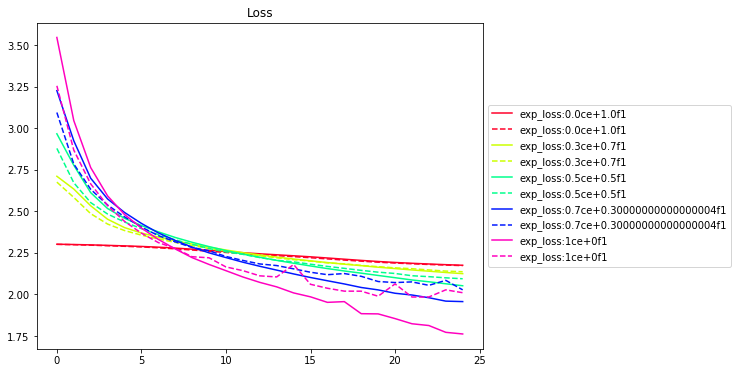

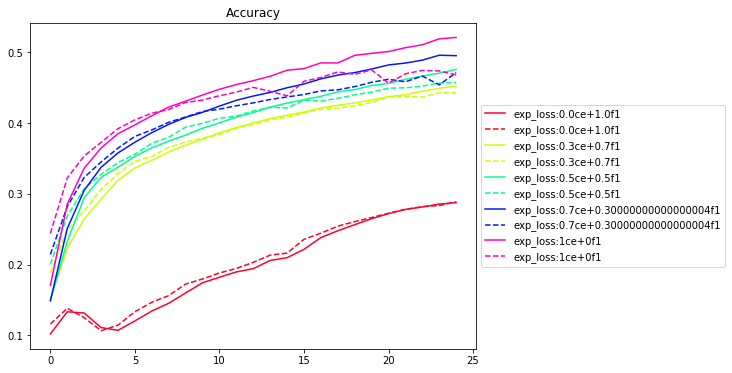

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()